# t-SNE representation of +ve and -ve review of amazon product
# Avg W2V of sentences  and Avg W2V TFIDF of sentences



In [3]:
from sklearn.manifold import TSNE
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

con = sqlite3.connect('clean_data.sqlite') 
clean_data = pd.read_sql_query("""SELECT * FROM Reviews1 WHERE Score != 3""", con) 
clean_data['CleandeText'].head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
1912,48260,52448,B0042GZSU0,A3O72QQH1KAY4U,Shirley W. Garrison,1,2,positive,1318291200,Gordon Birthday gift,Excellent service. Great product. My nephew lo...,b'excel servic great product nephew love gift ...
2102,454307,491176,B003LD42BQ,AKB4YIGXUMDS1,Sara M. Wright,1,1,positive,1284163200,Life long Airwaves fanatic...,"I was 14 the first time I tried Airwaves gum, ...",b'first time tri airwav gum absolut love almos...
1137,351157,379863,B001EO605K,ADV0YUWMHKIBA,The Brogdons,0,0,positive,1331337600,Love these things! Satisfies that salt cravin...,"Tasty little strips, slightly spicy, with grea...",b'tasti littl strip slight spici great umami f...
2206,455477,492444,B000K73F28,A2S47MKDKS1EYH,Kay,1,1,positive,1323648000,yummy,"Claxton fruitcake is moist, fruity, not too sp...",b'claxton fruitcak moist fruiti spici short be...
863,456922,494051,B000I6O6P6,A2K2VAMTQ35B96,"H. Asaad ""dvdthebest""",5,5,positive,1210982400,Best Flavored Coffee,"Its one of the best flavored coffee in the US,...",b'one best flavor coffe full flavor caramel sp...


In [2]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
import gensim
i=0
#create a list of list to be used in W2V 
list_of_sent=[]
for sent in clean_data['CleanedText'].values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        #for cleaned_words in cleanpunc(w).split():
         for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower().decode('utf8'))
            else:
                continue 
    list_of_sent.append(filtered_sentence)
#convert each sentence's words to a vector of 50 dimension. Dont construct vec if word doesnot occur 5 times. And for each word construct 50 dimension vector
#and 4 core processor
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)   


C:\Users\suman\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# average Word2Vec
# for each sentence make average of vectors by (vectors of each words)/(total no of words)
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)  

#Sent_vectors ready for tsne   

In [25]:
print(len(sent_vectors))
print(len(sent_vectors[0]))

4000
50


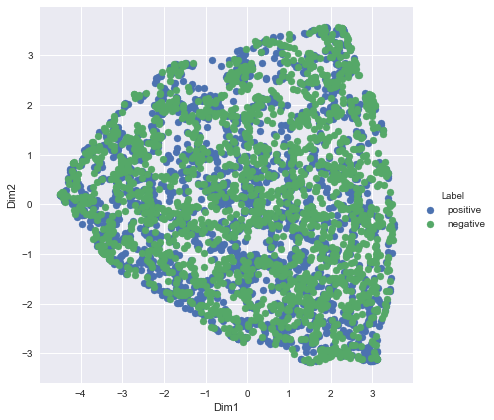

In [13]:
x=sent_vectors
y=clean_data['Score']
model=TSNE(n_components=2,random_state=0,perplexity=10,n_iter=250)
tsne_data=model.fit_transform(x)
#create new data for plotting
tsne_data=np.vstack((tsne_data.T,y)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=('Dim1','Dim2','Label'))
sns.FacetGrid(tsne_df,hue='Label',size=6).map(plt.scatter,'Dim1','Dim2').add_legend()
plt.show()

In [14]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()
final_tf_idf=tf_idf_vect.fit_transform(clean_data['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
#calculate avg tfidf score for each sentences 
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]#calculate w2v for each word
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]#get tfidf score of each word 
            sent_vec += (vec * tf_idf) # multiply vec with tfidf of each word and cumulative add of words in each sentence
            weight_sum += tf_idf # also add tfidf sums in each sentence
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
#tfidf_sent_vectors.


In [16]:
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))
#tfidf_feat
#sent_vectors
#tfidf_feat
#final_tf_idf[0]

4000
50


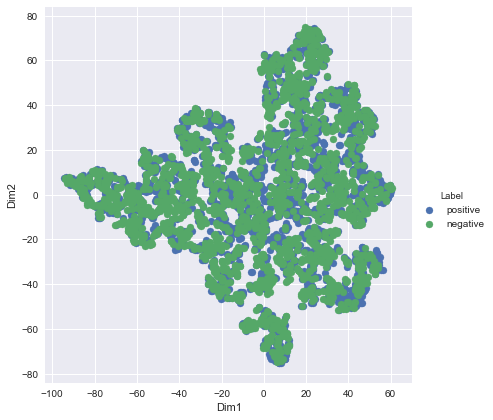

In [17]:
x=tfidf_sent_vectors
y=clean_data['Score']
model=TSNE(n_components=2,random_state=0)#,perplexity=10,n_iter=250)
tsne_data=model.fit_transform(x)
#create new data for plotting
tsne_data=np.vstack((tsne_data.T,y)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=('Dim1','Dim2','Label'))
sns.FacetGrid(tsne_df,hue='Label',size=6).map(plt.scatter,'Dim1','Dim2').add_legend()
plt.show()